In [82]:
from collections import defaultdict
import csv
from glob import glob
import json
import os.path as osp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 50)

In [83]:
EXP_PREFIX = "/home/rjulian/code/garage/data/local/ppo-point-embed/"
EXP_LEN = 500

In [84]:
# Find and load experiments
experiments = {}
exp_names = []
exp_data = []

# Load variant files and CSVs
for e in glob(EXP_PREFIX + "/**/variant.json"):
    with open(e) as f:
        v = json.load(f)
        v_path = osp.dirname(e)
        
        # Add path data
        v["path"] = v_path
        
        # Get CSV data
        df = pd.read_csv(osp.join(v_path, "progress.csv"))
        # Add entropy coeffs
        coeff = np.full_like(df["Iteration"], v["policy_ent_coeff"], dtype=np.float64)
        df = df.assign(policy_ent_coeff=coeff)
        coeff = np.full_like(df["Iteration"], v["embedding_ent_coeff"], dtype=np.float64)
        df = df.assign(embedding_ent_coeff=coeff)
        coeff = np.full_like(df["Iteration"], v["inference_ce_coeff"], dtype=np.float64)
        df = df.assign(inference_ce_coeff=coeff)

        v["csv"] = df
        experiments[v["exp_name"]] = v
        exp_names.append(v["exp_name"])
        exp_data.append(df)

exp_data = pd.concat(exp_data, keys=exp_names, sort=True)
# exp_data = pd.concat(exp_data, sort=True)
print("Loaded {} experiments...".format(len(experiments)))

Loaded 355 experiments...


In [94]:
# Best hyperparams so far
hyp_data = exp_data.groupby(["policy_ent_coeff", "embedding_ent_coeff", "inference_ce_coeff"])
min_perf = exp_data[["Tasks/CompletionRate/t=0", 
                     "Tasks/CompletionRate/t=1", 
                     "Tasks/CompletionRate/t=2", 
                     "Tasks/CompletionRate/t=3"]].min(axis=1)
exp_data = exp_data.assign(min_completion_rate=min_perf)

# Add some conditions
filtered = exp_data.loc[
    (exp_data["Tasks/Entropy/t=0"] > 0) & \
    (exp_data["Tasks/Entropy/t=1"] > 0) & \
    (exp_data["Tasks/Entropy/t=2"] > 0) & \
    (exp_data["Tasks/Entropy/t=3"] > 0) & \
    (exp_data["min_completion_rate"] > 0)
]


# filtered.sort_values(by="min_completion_rate", ascending=False)
filtered.sort_values(by="AverageDiscountedReturn", ascending=False)

AverageDiscountedReturn  \
ppo_point_embed_2018_07_13_11_01_54_0282 32               -43.308698   
ppo_point_embed_2018_07_13_11_01_54_0285 37               -44.012818   
ppo_point_embed_2018_07_13_11_01_54_0282 31               -45.344045   
                                         33               -46.488982   
ppo_point_embed_2018_07_13_11_01_54_0285 36               -46.572192   
ppo_point_embed_2018_07_13_11_01_54_0282 34               -46.837304   
                                         36               -47.489972   
ppo_point_embed_2018_07_13_11_01_54_0285 35               -48.538054   
ppo_point_embed_2018_07_13_11_01_54_0282 35               -48.972041   
                                         27               -53.585629   
ppo_point_embed_2018_07_13_11_01_54_0285 30               -58.363108   
                                         29               -60.110923   
ppo_point_embed_2018_07_13_11_01_54_0282 23               -69.204437   

                                             AveragePolicyStd  AverageReturn  \
ppo_point_embed_2018_07_13_11_01_54_0282 32          5.155765     -45.950019   
ppo_point_embed_2018_07_13_11_01_54_0285 37          4.746389     -46.959002   
ppo_point_embed_2018_07_13_11_01_54_0282 31          5.228128     -49.115894   
                                         33          5.128435     -50.783205   
ppo_point_embed_2018_07_13_11_01_54_0285 36          4.811733     -50.052333   
ppo_point_embed_2018_07_13_11_01_54_0282 34          5.053679     -51.480972   
                                         36          4.889992     -53.061177   
ppo_point_embed_2018_07_13_11_01_54_0285 35          4.814920     -52.941928   
ppo_point_embed_2018_07_13_11_01_54_0282 35          5.058576     -54.388693   
                                         27          5.310698     -60.045635   
ppo_point_embed_2018_07_13_11_01_54_0285 30          5.125969     -66.804941   
                                         29          5.076696     -68.956452   
ppo_point_embed_2018_07_13_11_01_54_0282 23          5.457210     -81.622564   

                                             Baseline/ExplainedVariance  \
ppo_point_embed_2018_07_13_11_01_54_0282 32                    0.151175   
ppo_point_embed_2018_07_13_11_01_54_0285 37                    0.107330   
ppo_point_embed_2018_07_13_11_01_54_0282 31                    0.132943   
                                         33                    0.176762   
ppo_point_embed_2018_07_13_11_01_54_0285 36                    0.071325   
ppo_point_embed_2018_07_13_11_01_54_0282 34                    0.162079   
                                         36                    0.097306   
ppo_point_embed_2018_07_13_11_01_54_0285 35                    0.161769   
ppo_point_embed_2018_07_13_11_01_54_0282 35                    0.021584   
                                         27                    0.194369   
ppo_point_embed_2018_07_13_11_01_54_0285 30                    0.225315   
                                         29                    0.265028   
ppo_point_embed_2018_07_13_11_01_54_0282 23                    0.417972   

                                             Embedding/Entropy  Embedding/KL  \
ppo_point_embed_2018_07_13_11_01_54_0282 32           0.695677      0.065475   
ppo_point_embed_2018_07_13_11_01_54_0285 37           0.418173      0.024274   
ppo_point_embed_2018_07_13_11_01_54_0282 31           0.649768      0.159617   
                                         33           0.677675      0.647036   
ppo_point_embed_2018_07_13_11_01_54_0285 36           0.483645      0.449936   
ppo_point_embed_2018_07_13_11_01_54_0282 34           0.610655      0.699094   
                                         36           0.488883      0.161595   
ppo_point_embed_2018_07_13_11_01_54_0285 35           0.452114      0.153813   
ppo_point_embed_2018_07_13_11_01_54_0282 35           0.535969      0.081767   
                                         27           0.783919  

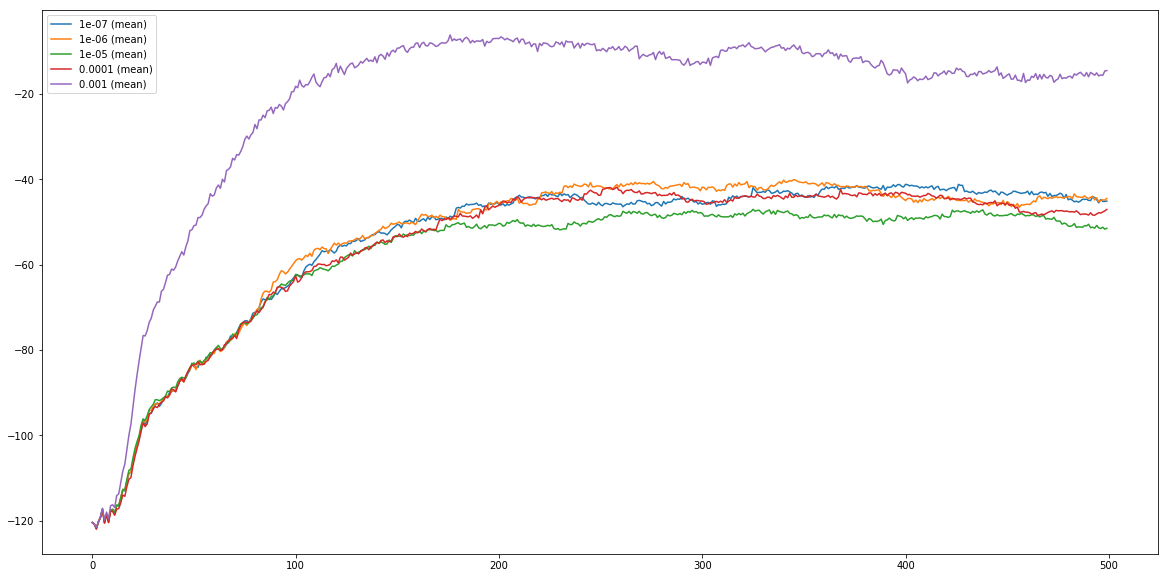

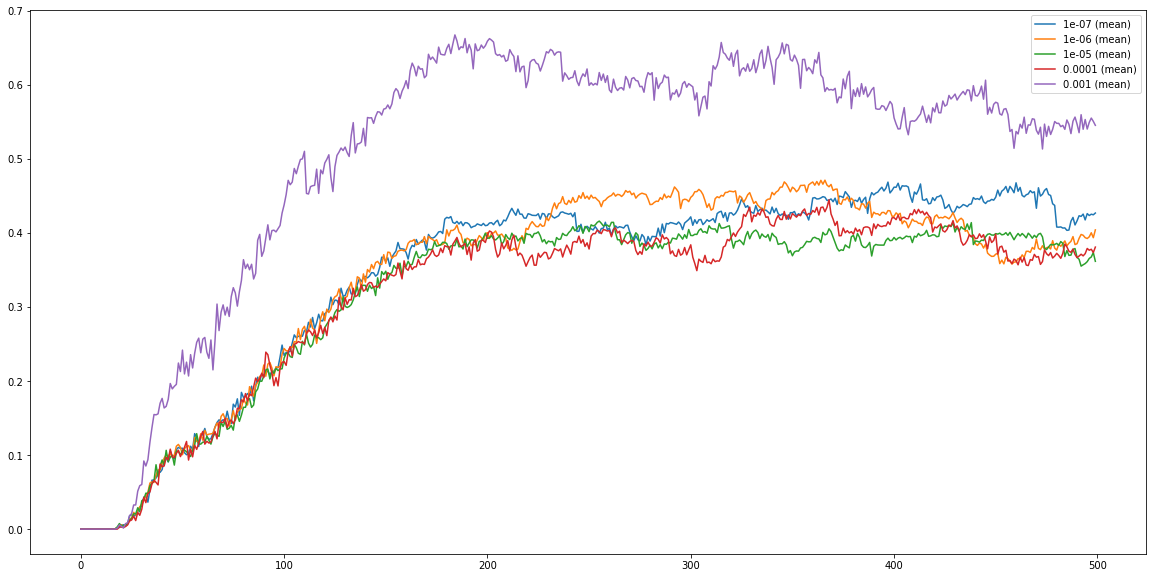

In [87]:
# Plot by policy_ent_coeff
pec_data = exp_data.groupby("policy_ent_coeff")
fig, ax = plt.subplots(figsize=(20,10))
fig2, ax2 = plt.subplots(figsize=(20,10))
for pec in sorted(pec_data.groups.keys()):
    maxs = pec_data.get_group(pec).groupby("Iteration").max()
    mins = pec_data.get_group(pec).groupby("Iteration").min()
    means = pec_data.get_group(pec).groupby("Iteration").mean()
    medians = pec_data.get_group(pec).groupby("Iteration").median()
    
    # AverageDiscountedReturn
    p = ax.plot(means.index, means["AverageDiscountedReturn"], label="{} (mean)".format(str(pec)))
    c = p[0].get_color()
    # ax.plot(maxs.index, maxs["AverageDiscountedReturn"], label="{} (max)".format(str(pec)), color=c
    # ax.plot(mins.index, mins["AverageDiscountedReturn"], label="{} (min)".format(str(pec)), color=c)
    ax.legend()
    
    # min(CompletionRate)
    min_mean_comp_rate = means[["Tasks/CompletionRate/t=0", 
                                "Tasks/CompletionRate/t=1", 
                                "Tasks/CompletionRate/t=2", 
                                "Tasks/CompletionRate/t=3"]].min(axis=1)
    ax2.plot(means.index, min_mean_comp_rate, label="{} (mean)".format(str(pec)))
    ax2.legend()

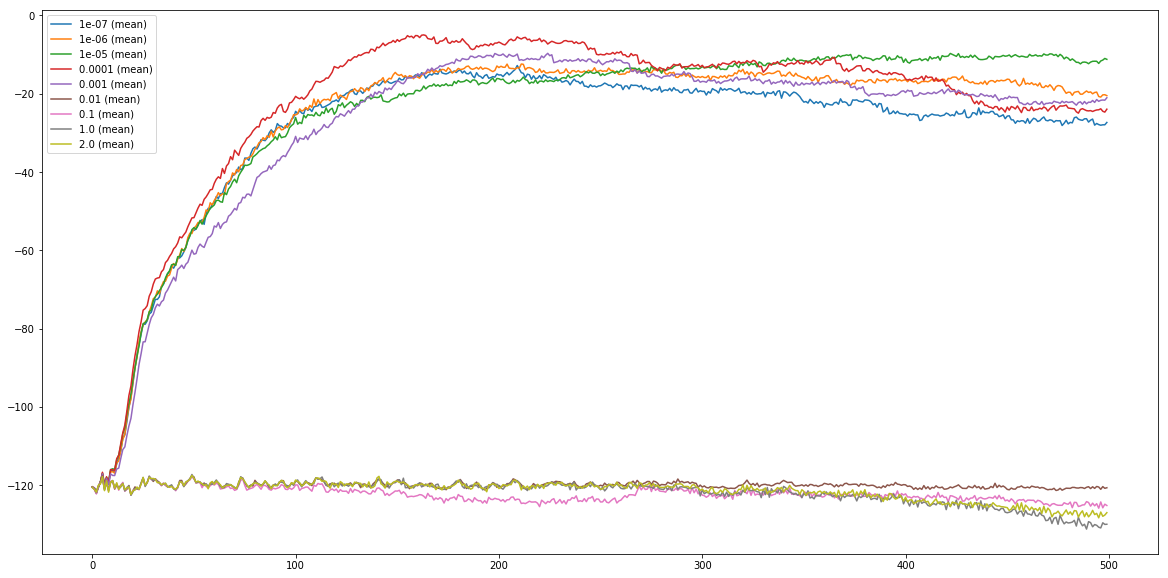

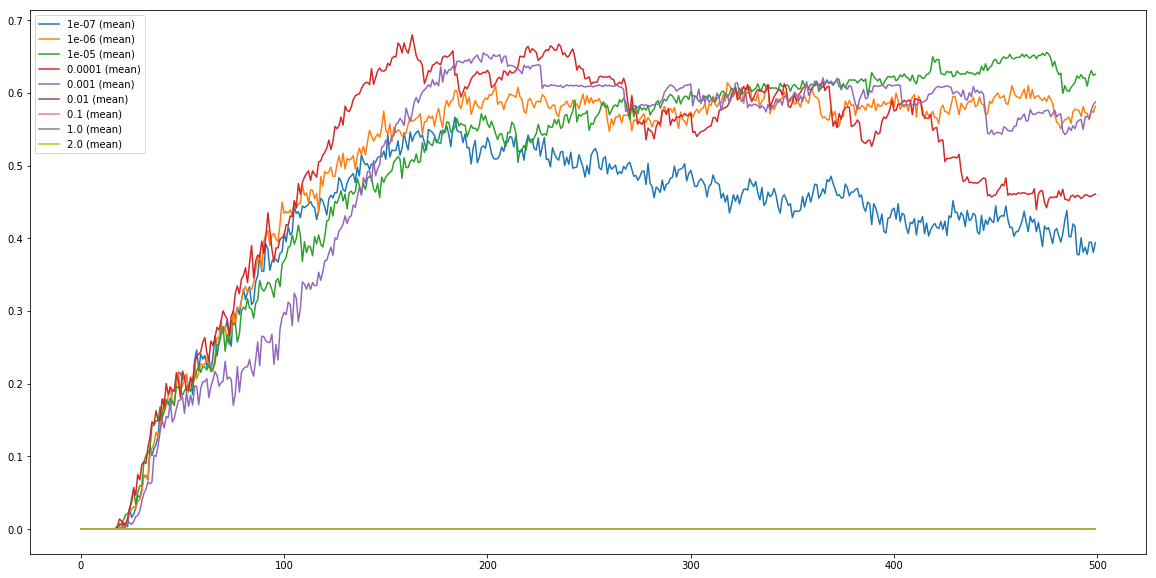

In [88]:
# Plot by embedding_ent_coeff
fig, ax = plt.subplots(figsize=(20,10))
fig2, ax2 = plt.subplots(figsize=(20,10))
eec_data = exp_data.groupby("embedding_ent_coeff")
for eec in sorted(eec_data.groups.keys()):
    means = eec_data.get_group(eec).groupby("Iteration").mean()
    maxs = eec_data.get_group(eec).groupby("Iteration").max()
    mins = eec_data.get_group(eec).groupby("Iteration").min()
    medians = eec_data.get_group(eec).groupby("Iteration").median()
    
    # AverageDiscountedReturn
    p = ax.plot(means.index, means["AverageDiscountedReturn"], label="{} (mean)".format(str(eec)))
    c = p[0].get_color()
    # ax.plot(maxs.index, maxs["AverageDiscountedReturn"], label="{} (max)".format(str(eec)), color=c)
    # ax.plot(mins.index, mins["AverageDiscountedReturn"], label="{} (min)".format(str(eec)), color=c)
    ax.legend()
    
    # min(CompletionRate)
    min_mean_comp_rate = means[["Tasks/CompletionRate/t=0", 
                                "Tasks/CompletionRate/t=1", 
                                "Tasks/CompletionRate/t=2", 
                                "Tasks/CompletionRate/t=3"]].min(axis=1)
    ax2.plot(means.index, min_mean_comp_rate, label="{} (mean)".format(str(eec)))
    ax2.legend()

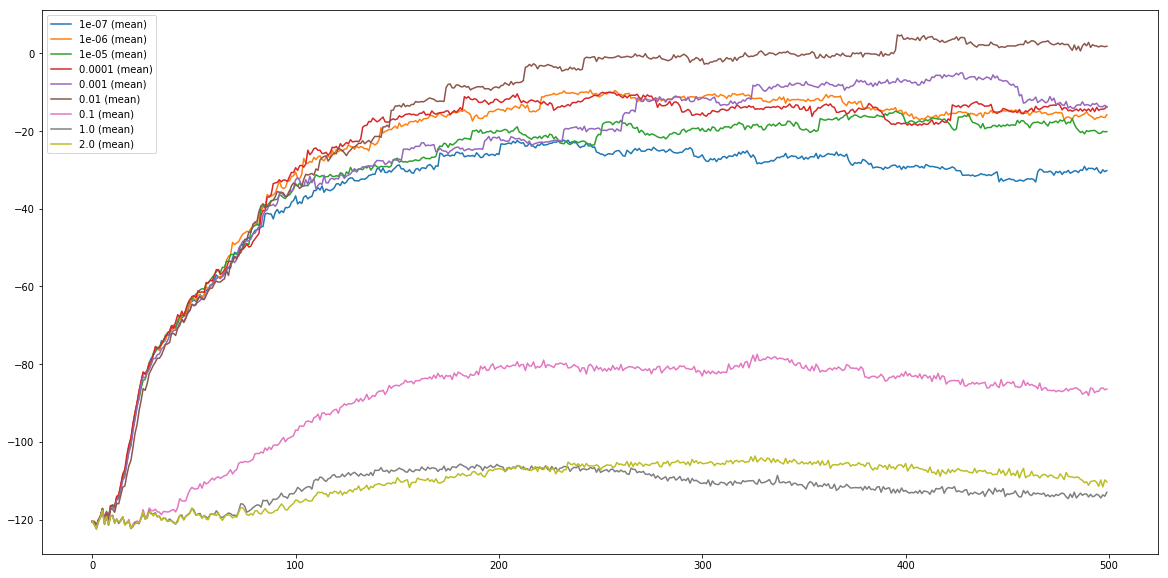

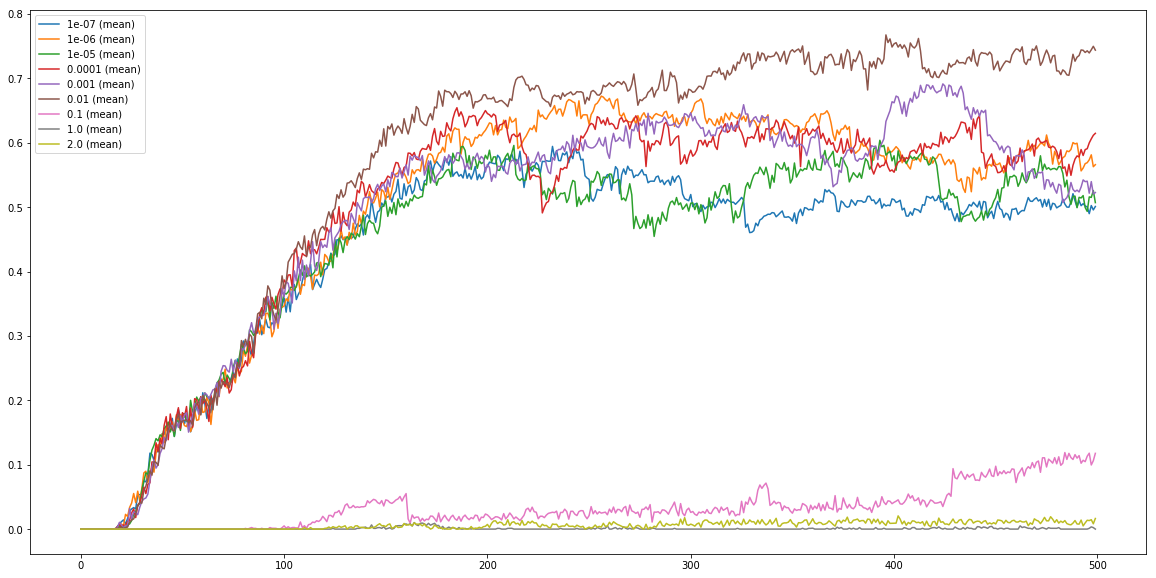

In [89]:
# Plot by inference_ce_coeff
fig, ax = plt.subplots(figsize=(20,10))
fig2, ax2 = plt.subplots(figsize=(20,10))
icc_data = exp_data.groupby("inference_ce_coeff")
for icc in sorted(icc_data.groups.keys()):
    means = icc_data.get_group(icc).groupby("Iteration").mean()
    maxs = icc_data.get_group(icc).groupby("Iteration").max()
    mins = icc_data.get_group(icc).groupby("Iteration").min()
    medians = icc_data.get_group(icc).groupby("Iteration").median()
    
    # AverageDiscountedReturn
    p = ax.plot(means.index, means["AverageDiscountedReturn"], label="{} (mean)".format(str(icc)))
    c = p[0].get_color()
    # ax.plot(maxs.index, maxs["AverageDiscountedReturn"], label="{} (max)".format(str(icc)), color=c)
    # ax.plot(mins.index, mins["AverageDiscountedReturn"], label="{} (min)".format(str(icc)), color=c)
    ax.legend()
    
    # min(CompletionRate)
    min_mean_comp_rate = means[["Tasks/CompletionRate/t=0", 
                                "Tasks/CompletionRate/t=1", 
                                "Tasks/CompletionRate/t=2", 
                                "Tasks/CompletionRate/t=3"]].min(axis=1)
    ax2.plot(means.index, min_mean_comp_rate, label="{} (mean)".format(str(icc)))
    ax2.legend()